In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from pandas import set_option
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import Birch

%matplotlib inline

import matplotlib.colors as colors
from itertools import cycle

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [3]:
# load dataset
train_dataset = pd.read_csv("CensusCanada2016Training.csv")
test_dataset = pd.read_csv("CensusCanada2016Test.csv")

In [4]:
train_dataset.head(5)

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter
0,4051,1441,68242.12,1441,323,199,53,182,526,911,525,5,1343,919,424
1,2329,1026,88172.37,1026,927,70,15,3,0,792,230,4,991,778,213
2,5276,2071,103853.38,2071,3,607,567,651,106,1418,652,1,1903,1522,381
3,5967,2203,82796.63,2203,133,1695,248,79,0,1397,806,0,2079,1272,807
4,4236,1419,91648.22,1419,0,7,127,938,143,914,505,0,1348,1186,162


In [5]:
train_dataset.shape

(5000, 15)

In [6]:
test_dataset.shape

(721, 14)

In [7]:
def data_pre_process(df):
    df['Proportion of Households For Period Of Construction Built Before 1961'] = df['Total Households For Period Of Construction Built Before 1961'] / df['Total Households']
    df['Proportion of Households For Period Of Construction Built Between 1961 And 1980'] = df['Total Households For Period Of Construction Built Between 1961 And 1980'] / df['Total Households']
    df['Proportion of Households For Period Of Construction Built Between 1981 And 190'] = df['Total Households For Period Of Construction Built Between 1981 And 190'] / df['Total Households']
    df['Proportion of Households For Period Of Construction Built Between 1991 And 2000'] = df['Total Households For Period Of Construction Built Between 1991 And 2000'] / df['Total Households']
    df['Proportion of Households For Period Of Construction Built Between 2001 And 2005'] = df['Total Households For Period Of Construction Built Between 2001 And 2005'] / df['Total Households']
    df['Proportion of Households For Structure Type Houses'] = df['Total Households For Structure Type Houses'] / df['Total Households']
    df['Proportion of Households For Structure Type Other Dwelling Types'] = df['Total Households For Structure Type Other Dwelling Types'] / df['Total Households']
    df['Proportion of Households For Tenure'] = df['Total Households for Tenure'] / df['Total Households']
    df['Proportion of Dwellings by Tenure Owner'] = df['Dwellings by Tenure Owner'] / df['Total Households for Tenure']
    
    df = df.drop(['Total Households For Period Of Construction'], axis = 1)
    df = df.drop(['Total Households For Period Of Construction Built Before 1961'], axis = 1)
    df = df.drop(['Total Households For Period Of Construction Built Between 1961 And 1980'], axis = 1)
    df = df.drop(['Total Households For Period Of Construction Built Between 1981 And 190'], axis = 1)
    df = df.drop(['Total Households For Period Of Construction Built Between 1991 And 2000'], axis = 1)
    df = df.drop(['Total Households For Period Of Construction Built Between 2001 And 2005'], axis = 1)   
    df = df.drop(['Total Households For Structure Type Houses'], axis = 1)
    df = df.drop(['Total Households For Structure Type Apartment, Building Low And High Rise'], axis = 1)
    df = df.drop(['Total Households For Structure Type Other Dwelling Types'], axis = 1)
    df = df.drop(['Total Households for Tenure'], axis = 1)
    df = df.drop(['Dwellings by Tenure Owner'], axis = 1)
    df = df.drop(['Dwellings by Tenure Renter'], axis = 1)
    df = df.drop(['Total Population'], axis = 1)
    
    return df

In [8]:
train_new = data_pre_process(train_dataset)
test_new = data_pre_process(test_dataset)

In [9]:
train_new = train_new.fillna(0)
test_new = test_new.fillna(0)

In [10]:
train_new = train_new.drop(train_new[train_new['Median Household Income (Current Year $)'] == 0].index)

In [11]:
set_option('precision', 2)
train_new.describe()

,Total Households,Median Household Income (Current Year $),Proportion of Households For Period Of Construction Built Before 1961,Proportion of Households For Period Of Construction Built Between 1961 And 1980,Proportion of Households For Period Of Construction Built Between 1981 And 190,Proportion of Households For Period Of Construction Built Between 1991 And 2000,Proportion of Households For Period Of Construction Built Between 2001 And 2005,Proportion of Households For Structure Type Houses,Proportion of Households For Structure Type Other Dwelling Types,Proportion of Households For Tenure,Proportion of Dwellings by Tenure Owner
count,4980.00,4980.00,4980.00,4980.00,4980.00,4980.00,4980.00,4980.00,4.98e+03,4980.00,4980.00
mean,1935.52,77551.28,0.22,0.30,0.14,0.12,0.07,0.62,1.08e-02,0.94,0.66
std,969.06,33076.78,0.23,0.20,0.13,0.13,0.10,0.31,4.58e-02,0.08,0.24
min,1.00,11334.98,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00,0.00
25%,1341.00,53201.36,0.03,0.15,0.05,0.04,0.01,0.39,0.00e+00,0.93,0.50
50%,1827.00,76328.30,0.14,0.27,0.10,0.08,0.03,0.70,8.04e-04,0.94,0.72
75%,2433.00,95554.43,0.36,0.42,0.18,0.16,0.08,0.89,4.35e-03,0.96,0.86
max,15388.00,669559.56,1.00,1.00,0.89,1.00,0.86,1.00,1.00e+00,3.00,1.00


In [12]:
correlation = train_new.corr(method = "pearson")
set_option('precision', 2)
correlation.style.background_gradient(cmap = 'coolwarm')

,Total Households,Median Household Income (Current Year $),Proportion of Households For Period Of Construction Built Before 1961,Proportion of Households For Period Of Construction Built Between 1961 And 1980,Proportion of Households For Period Of Construction Built Between 1981 And 190,Proportion of Households For Period Of Construction Built Between 1991 And 2000,Proportion of Households For Period Of Construction Built Between 2001 And 2005,Proportion of Households For Structure Type Houses,Proportion of Households For Structure Type Other Dwelling Types,Proportion of Households For Tenure,Proportion of Dwellings by Tenure Owner
Total Households,1,-0.037,-0.19,-0.086,-0.045,0.0026,0.11,-0.18,-0.11,-0.076,-0.068
Median Household Income (Current Year $),-0.037,1,-0.27,-0.23,0.12,0.24,0.27,0.59,-0.0035,-0.0096,0.64
Proportion of Households For Period Of Construction Built Before 1961,-0.19,-0.27,1,-0.083,-0.41,-0.45,-0.38,-0.31,-0.047,0.084,-0.38
Proportion of Households For Period Of Construction Built Between 1961 And 1980,-0.086,-0.23,-0.083,1,-0.02,-0.42,-0.47,-0.09,-0.019,0.14,-0.18
Proportion of Households For Period Of Construction Built Between 1981 And 190,-0.045,0.12,-0.41,-0.02,1,0.2,-0.16,0.15,0.018,0.059,0.19
Proportion of Households For Period Of Construction Built Between 1991 And 2000,0.0026,0.24,-0.45,-0.42,0.2,1,0.32,0.23,0.033,-0.051,0.3
Proportion of Households For Period Of Construction Built Between 2001 And 2005,0.11,0.27,-0.38,-0.47,-0.16,0.32,1,0.23,-0.0069,-0.042,0.29
Proportion of Households For Structure Type Houses,-0.18,0.59,-0.31,-0.09,0.15,0.23,0.23,1,-0.017,0.036,0.84
Proportion of Households For Structure Type Other Dwelling Types,-0.11,-0.0035,-0.047,-0.019,0.018,0.033,-0.0069,-0.017,1,-0.0076,0.047
Proportion of Households For Tenure,-0.076,-0.0096,0.084,0.14,0.059,-0.051,-0.042,0.036,-0.0076,1,0.06


In [13]:
def normalize_data(dataset):
    scaler = preprocessing.MinMaxScaler()
    scaled_dataset = scaler.fit_transform(dataset)
    return scaled_dataset

In [14]:
train_scaled = normalize_data(train_new)
test_scaled = normalize_data(test_new)

In [15]:
ks = range(1, 25)
# Inertia: Sum of Square distance to respective centroid
inertias = []

In [16]:
for k in ks:
    # run k-means with k clusters
    model = KMeans(n_clusters=k)
    # fit the model
    model.fit(train_scaled)
    # append inertia value
    inertias.append(model.inertia_)
inertias

[1527.5093009632142,
 938.5898108233332,
 778.4524499618838,
 646.8132900666932,
 584.0849474753021,
 526.6808026780585,
 484.50396984262113,
 447.0324865890343,
 417.05271680131193,
 390.94380835613657,
 370.58056198387715,
 353.4601492194462,
 339.6228585702554,
 326.9964076415891,
 316.7989329762991,
 304.3245503134062,
 295.7396816747928,
 289.0119221041547,
 280.51901813307376,
 273.12896896167524,
 267.00458501040083,
 261.03640425275694,
 257.0726516192065,
 250.62156162037783]

([<matplotlib.axis.XTick at 0x246f6a3a248>,
 <a list of 24 Text xticklabel objects>)

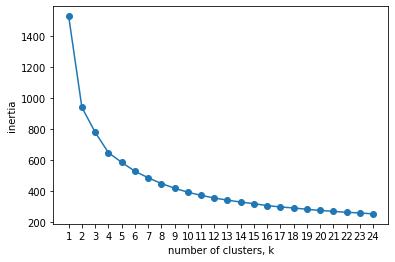

In [17]:
# plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel("number of clusters, k")
plt.ylabel("inertia")
plt.xticks(ks)

In [18]:
def KMeansModel(data):
    model = KMeans(n_clusters = 2)
    model.fit(data)
    # determine the cluster labels of points
    return model

In [19]:
KMeansTrainingSetModel = KMeansModel(train_scaled)
labels = KMeansTrainingSetModel.predict(train_scaled)
labels

array([1, 1, 1, ..., 0, 1, 1])

In [20]:
centroids = KMeansTrainingSetModel.cluster_centers_
centroids

array([[0.13524011, 0.06516596, 0.34651537, 0.31378823, 0.11627989,
        0.07964831, 0.04184149, 0.27316679, 0.00751664, 0.31293178,
        0.41131771],
       [0.1201624 , 0.12130762, 0.14957821, 0.28701311, 0.17718112,
        0.14873735, 0.09755606, 0.81860879, 0.01273941, 0.31491049,
        0.80623249]])

In [21]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
scaler = preprocessing.MinMaxScaler()
scaler.fit_transform(train_new)

array([[0.093585, 0.086456, 0.224150, ..., 0.003470, 0.310664, 0.684289],
       [0.066615, 0.116734, 0.903509, ..., 0.003899, 0.321962, 0.785066],
       [0.134529, 0.140557, 0.001449, ..., 0.000483, 0.306293, 0.799790],
       ...,
       [0.123091, 0.091208, 0.086544, ..., 0.094987, 0.310290, 0.691043],
       [0.067395, 0.071288, 0.524085, ..., 0.000000, 0.286769, 0.611422],
       [0.118867, 0.152110, 0.006011, ..., 0.000000, 0.307286, 0.882039]])

In [22]:
pd.DataFrame(scaler.inverse_transform(centroids), columns = train_new.columns)

,Total Households,Median Household Income (Current Year $),Proportion of Households For Period Of Construction Built Before 1961,Proportion of Households For Period Of Construction Built Between 1961 And 1980,Proportion of Households For Period Of Construction Built Between 1981 And 190,Proportion of Households For Period Of Construction Built Between 1991 And 2000,Proportion of Households For Period Of Construction Built Between 2001 And 2005,Proportion of Households For Structure Type Houses,Proportion of Households For Structure Type Other Dwelling Types,Proportion of Households For Tenure,Proportion of Dwellings by Tenure Owner
0,2081.94,54228.82,0.35,0.31,0.10,0.08,0.04,0.27,7.52e-03,0.94,0.41
1,1849.94,91182.63,0.15,0.29,0.16,0.15,0.08,0.82,1.27e-02,0.94,0.81


In [23]:
#BIRCH clustering
brc = Birch(branching_factor = 50, n_clusters = 2, threshold = 0.5)
brc.fit(train_scaled)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=2,
      threshold=0.5)

In [24]:
pred = brc.predict(train_scaled)
pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

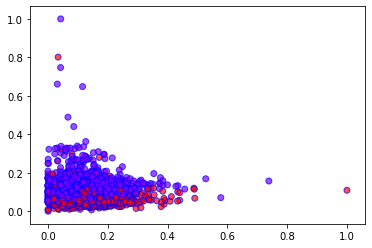

In [25]:
plt.scatter(train_scaled[:,0], train_scaled[:,1], c = pred, cmap = 'rainbow', alpha = 0.7, edgecolors = 'b')

In [26]:
train_new['cluster'] = brc.labels_
birchcluster0 = train_new[train_new['cluster'] == 0]
birchcluster1 = train_new[train_new['cluster'] == 1]

In [27]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
birchcluster0

,Total Households,Median Household Income (Current Year $),Proportion of Households For Period Of Construction Built Before 1961,Proportion of Households For Period Of Construction Built Between 1961 And 1980,Proportion of Households For Period Of Construction Built Between 1981 And 190,Proportion of Households For Period Of Construction Built Between 1991 And 2000,Proportion of Households For Period Of Construction Built Between 2001 And 2005,Proportion of Households For Structure Type Houses,Proportion of Households For Structure Type Other Dwelling Types,Proportion of Households For Tenure,Proportion of Dwellings by Tenure Owner,cluster
0,1441,68242.12,2.24e-01,1.38e-01,0.04,1.26e-01,3.65e-01,0.63,3.47e-03,0.93,0.68,0
1,1026,88172.37,9.04e-01,6.82e-02,0.01,2.92e-03,0.00e+00,0.77,3.90e-03,0.97,0.79,0
2,2071,103853.38,1.45e-03,2.93e-01,0.27,3.14e-01,5.12e-02,0.68,4.83e-04,0.92,0.80,0
3,2203,82796.63,6.04e-02,7.69e-01,0.11,3.59e-02,0.00e+00,0.63,0.00e+00,0.94,0.61,0
4,1419,91648.22,0.00e+00,4.93e-03,0.09,6.61e-01,1.01e-01,0.64,0.00e+00,0.95,0.88,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4994,2201,53758.01,5.88e-01,2.43e-01,0.08,3.04e-02,6.36e-03,0.72,4.54e-03,0.93,0.52,0
4995,953,108823.38,0.00e+00,3.15e-03,0.03,5.26e-01,2.90e-01,0.97,0.00e+00,0.92,0.97,0
4996,3859,68735.64,1.76e-01,2.56e-01,0.10,9.30e-02,1.16e-01,0.62,9.07e-03,0.95,0.71,0
4998,1038,58258.26,5.24e-01,1.78e-01,0.04,9.15e-02,1.25e-02,0.77,0.00e+00,0.86,0.61,0


In [28]:
def KNNRegressorModel(X_train, Y_train):
    seed = 42
    num_folds = 10
    scoring = "neg_mean_squared_error"
    
    k_values = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
    param_grid = dict(n_neighbors = k_values)
    model = KNeighborsRegressor()
    kfold = KFold(n_splits = num_folds, random_state = seed)
    
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
    grid_result = grid.fit(X_train, Y_train)

    bestK = grid_result.best_params_['n_neighbors']

    # Develop KNN model for k = 19 (best k-value)
    KNNmodel = KNeighborsRegressor(n_neighbors = bestK)

    # Train it using X_train
    return KNNmodel.fit(X_train, Y_train)

In [29]:
def KNNRegressor(X_train, X_val, Y_train, Y_val):
    
    KNNModelFit = KNNRegressorModel(X_train, Y_train)
    # Run the trained model on rescaled X_test data to predict Y
    pred_scaled = KNNModelFit.predict(X_val)
    
    return mean_squared_error(Y_val, pred_scaled)

In [30]:
# function to create model
def create_model(neurons = 1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=11, activation="sigmoid"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [31]:
def ANNRegressor(X_train, X_val, Y_train, Y_val):
    
    ANNRegressorModel = KerasRegressor(build_fn=create_model, epochs=5, batch_size=5, verbose=1)
    # grid search parameters
    neurons = [5, 10, 15, 20]
    param_grid = dict(neurons = neurons)

    grid = GridSearchCV(estimator = ANNRegressorModel, param_grid= param_grid)

    grid_result = grid.fit(X_train, Y_train)
    bestNeuronNumber = grid_result.best_params_['neurons']
    
    def create_model_new():
        model = Sequential()
        model.add(Dense(bestNeuronNumber, input_dim=11, activation="sigmoid"))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        return model

    ANNRegressorModelUpdated = KerasRegressor(build_fn=create_model_new, epochs=5, batch_size=5, verbose=1)
    ANNRegressorModelUpdated.fit(X_train, Y_train, epochs=5, batch_size=5, verbose=2)
    
    val_predictions = ANNRegressorModelUpdated.predict(X_val)
    return mean_squared_error(Y_val, val_predictions)

In [32]:
def LinearRegressor(X_train, X_val, Y_train, Y_val):
    
    reg = LinearRegression().fit(X_train, Y_train)
    
    val_pred = reg.predict(X_val)
    return mean_squared_error(Y_val, val_pred)

In [33]:
def splitdata(data):
    dfX = data.drop(['Median Household Income (Current Year $)'], axis = 1)
    dfY = data['Median Household Income (Current Year $)']
    X_train, X_val, Y_train, Y_val = train_test_split(dfX, dfY, test_size=0.4, random_state=1)
    return X_train, X_val, Y_train, Y_val

In [46]:
train_new = train_new.drop('cluster', axis=1)

In [47]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train_new.columns)
train_scaled_df['cluster'] = labels
knncluster0 = train_scaled_df[train_scaled_df['cluster'] == 0]
knncluster1 = train_scaled_df[train_scaled_df['cluster'] == 1]

i=0
set_option('precision', 2)
MSE = pd.DataFrame(data={})
for cluster in [knncluster0, knncluster1]:
    X_train, X_val, Y_train, Y_val = splitdata(cluster)
    MSE.loc[i, 'KNN'] = KNNRegressor(X_train, X_val, Y_train, Y_val)
    MSE.loc[i, 'Linear'] = LinearRegressor(X_train, X_val, Y_train, Y_val)
    MSE.loc[i, 'ANN'] = ANNRegressor(X_train, X_val, Y_train, Y_val)
    i+=1

E:\apps\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/5
734/734 [==============================] - 0s 429us/step - loss: 0.4598 - accuracy: 0.0000e+00
Epoch 2/5
734/734 [==============================] - 0s 279us/step - loss: 0.3344 - accuracy: 0.0000e+00
Epoch 3/5
734/734 [==============================] - 0s 267us/step - loss: 0.2798 - accuracy: 0.0000e+00
Epoch 4/5
734/734 [==============================] - 0s 279us/step - loss: 0.2587 - accuracy: 0.0000e+00
Epoch 5/5
368/368 [==============================] - 0s 174us/step
Epoch 1/5
735/735 [==============================] - 0s 421us/step - loss: 0.5935 - accuracy: 0.0014
Epoch 2/5
735/735 [==============================] - 0s 302us/step - loss: 0.4189 - accuracy: 0.0014
Epoch 3/5
735/735 [==============================] - 0s 305us/step - loss: 0.3317 - accuracy: 0.0014
Epoch 4/5
735/735 [==============================] - 0s 273us/step - loss: 0.2878 - accuracy: 0.0014
Epoch 5/5
367/367 [==============================] - 0s 253us/step
Epoch 1/5
735/735 [=======================

E:\apps\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/5
1256/1256 [==============================] - 0s 398us/step - loss: 1.4322 - accuracy: 0.0000e+00
Epoch 2/5
1256/1256 [==============================] - 0s 325us/step - loss: 0.8334 - accuracy: 0.0000e+00
Epoch 3/5
1256/1256 [==============================] - 0s 282us/step - loss: 0.6371 - accuracy: 0.0000e+00
Epoch 4/5
1256/1256 [==============================] - 0s 281us/step - loss: 0.5467 - accuracy: 0.0000e+00
Epoch 5/5
629/629 [==============================] - 0s 149us/step
Epoch 1/5
1257/1257 [==============================] - 0s 386us/step - loss: 0.4706 - accuracy: 0.0000e+00
Epoch 2/5
1257/1257 [==============================] - 0s 356us/step - loss: 0.3770 - accuracy: 0.0000e+00
Epoch 3/5
1257/1257 [==============================] - 0s 257us/step - loss: 0.3703 - accuracy: 0.0000e+00
Epoch 4/5
1257/1257 [==============================] - 0s 257us/step - loss: 0.3699 - accuracy: 0.0000e+00
Epoch 5/5
628/628 [==============================] - 0s 162us/step
Epoch 1/5


In [48]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
MSE

,KNN,Linear,ANN
0,4.91e-04,5.41e-04,7.44e-04
1,2.11e-03,2.18e-03,2.51e-03


In [49]:
KMeansTestingSetModel = KMeansModel(test_scaled)
testLabels = KMeansTestingSetModel.predict(test_scaled)
testLabels

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,

In [50]:
test_scaled_df = pd.DataFrame(test_scaled, columns=test_new.columns)
test_scaled_df['cluster'] = testLabels
knnTestCluster0 = test_scaled_df[test_scaled_df['cluster'] == 0]
knnTestCluster1 = test_scaled_df[test_scaled_df['cluster'] == 1]

In [51]:
#Run KNN for Test clusters to predict income
i = 0
testPredictions = []
for cluster in [knnTestCluster0, knnTestCluster1]:
    trainingCluster = knncluster0 if i == 0 else knncluster1
    X_train, X_val, Y_train, Y_val = splitdata(trainingCluster)
    knnTestModel = KNNRegressorModel(X_train, Y_train)
    
    testPredictions.append(knnTestModel.predict(cluster))
    i+=1

In [52]:
preds = np.concatenate((testPredictions[0], testPredictions[1]))

In [53]:
train_new

,Total Households,Median Household Income (Current Year $),Proportion of Households For Period Of Construction Built Before 1961,Proportion of Households For Period Of Construction Built Between 1961 And 1980,Proportion of Households For Period Of Construction Built Between 1981 And 190,Proportion of Households For Period Of Construction Built Between 1991 And 2000,Proportion of Households For Period Of Construction Built Between 2001 And 2005,Proportion of Households For Structure Type Houses,Proportion of Households For Structure Type Other Dwelling Types,Proportion of Households For Tenure,Proportion of Dwellings by Tenure Owner
0,1441,68242.12,2.24e-01,1.38e-01,0.04,1.26e-01,0.37,0.63,3.47e-03,0.93,0.68
1,1026,88172.37,9.04e-01,6.82e-02,0.01,2.92e-03,0.00,0.77,3.90e-03,0.97,0.79
2,2071,103853.38,1.45e-03,2.93e-01,0.27,3.14e-01,0.05,0.68,4.83e-04,0.92,0.80
3,2203,82796.63,6.04e-02,7.69e-01,0.11,3.59e-02,0.00,0.63,0.00e+00,0.94,0.61
4,1419,91648.22,0.00e+00,4.93e-03,0.09,6.61e-01,0.10,0.64,0.00e+00,0.95,0.88
...,...,...,...,...,...,...,...,...,...,...,...
4995,953,108823.38,0.00e+00,3.15e-03,0.03,5.26e-01,0.29,0.97,0.00e+00,0.92,0.97
4996,3859,68735.64,1.76e-01,2.56e-01,0.10,9.30e-02,0.12,0.62,9.07e-03,0.95,0.71
4997,1895,71370.58,8.65e-02,2.56e-01,0.27,2.76e-01,0.02,0.36,9.50e-02,0.93,0.69
4998,1038,58258.26,5.24e-01,1.78e-01,0.04,9.15e-02,0.01,0.77,0.00e+00,0.86,0.61


In [54]:
testPredictions = np.reshape(preds, (-1, 1))
scaler = preprocessing.MinMaxScaler()
scaler.fit_transform(np.reshape(train_new.loc[:,'Median Household Income (Current Year $)'].values, (-1, 1)))
medianIncomes = scaler.inverse_transform(testPredictions)
len(medianIncomes)

721

In [55]:
data = medianIncomes

with open("Team3predictions.txt", "w") as txt_file:
    for income in medianIncomes:
        txt_file.write(str(round(income[0], 2)) + "\n") # works with any number of elements in a line